In [1]:
import numpy as np 
import pandas as pd

import os

In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
df = pd.read_csv('Training.csv')

# Visualizing the dataset
df.head(10)

# Checking for empty values
null_values = df.isnull().sum()
for cnt in null_values:
    assert cnt == 0

In [5]:
df.info()
# dtypes are already float64, no conversion needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


-0.9720799398422241

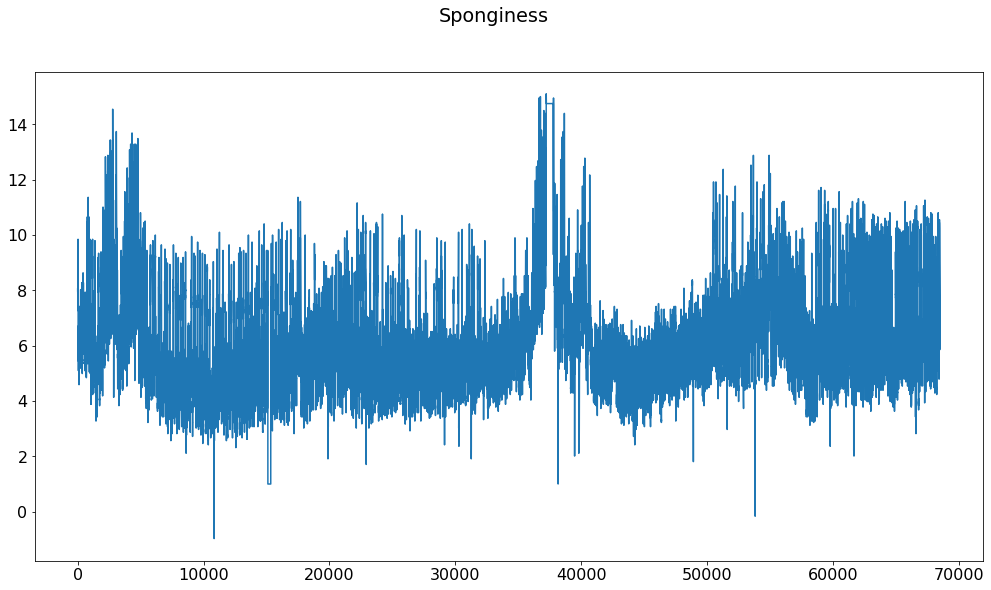

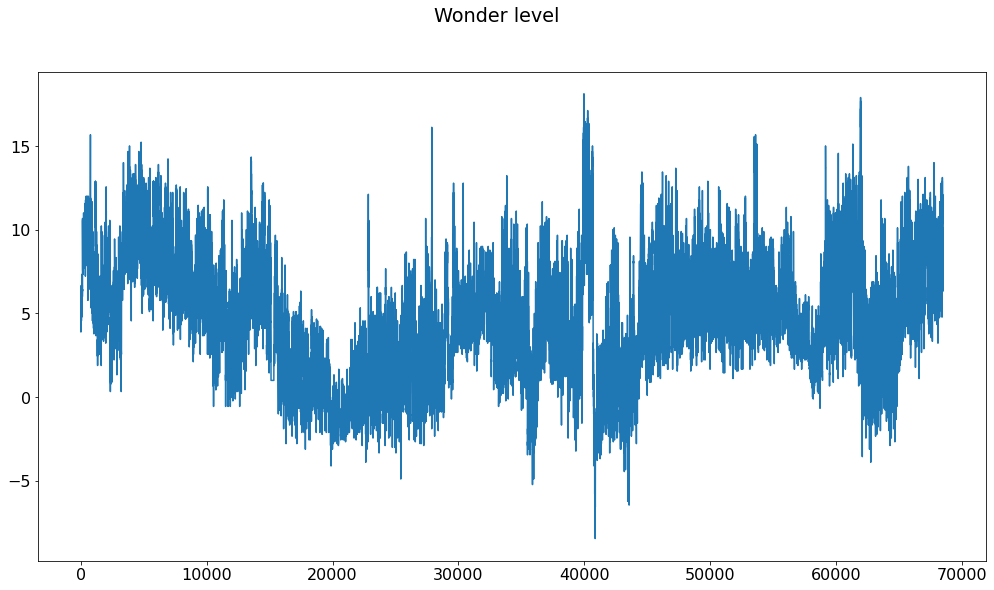

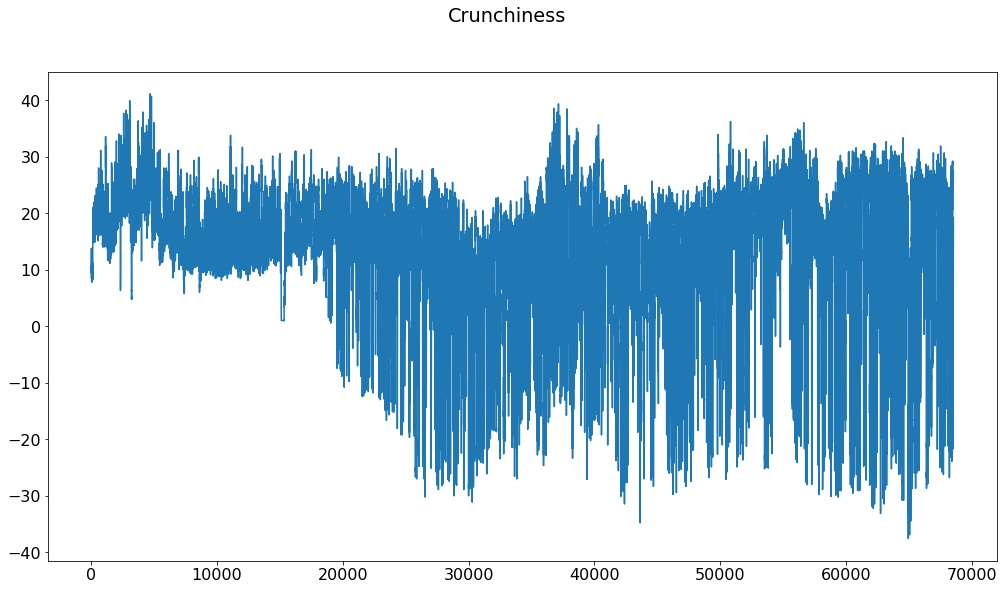

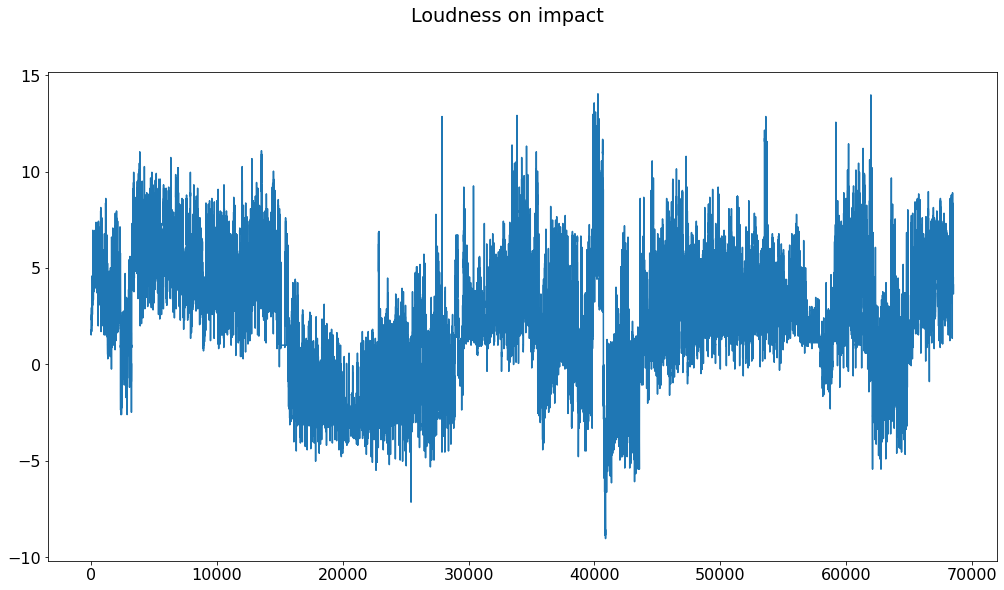

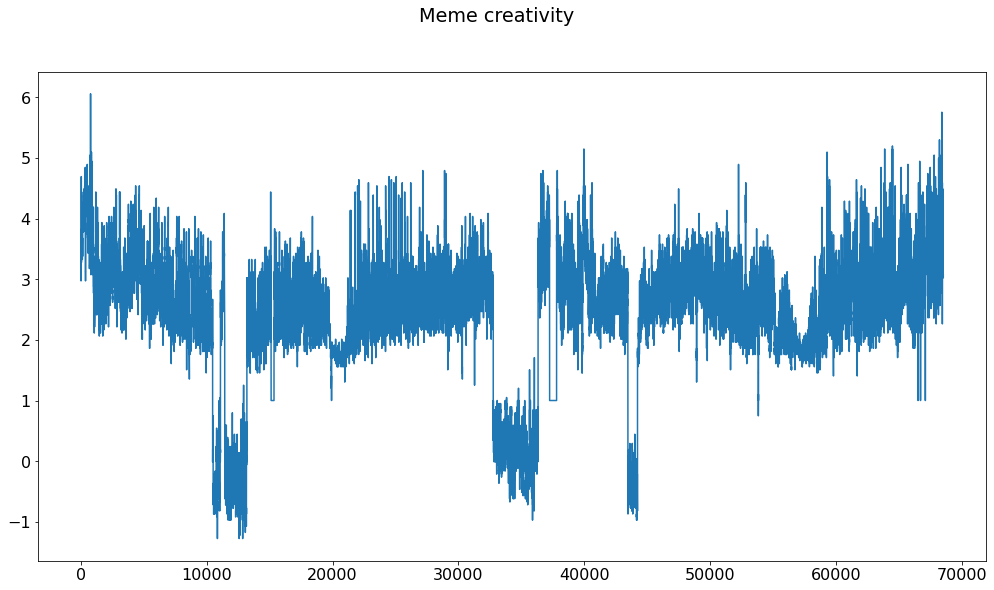

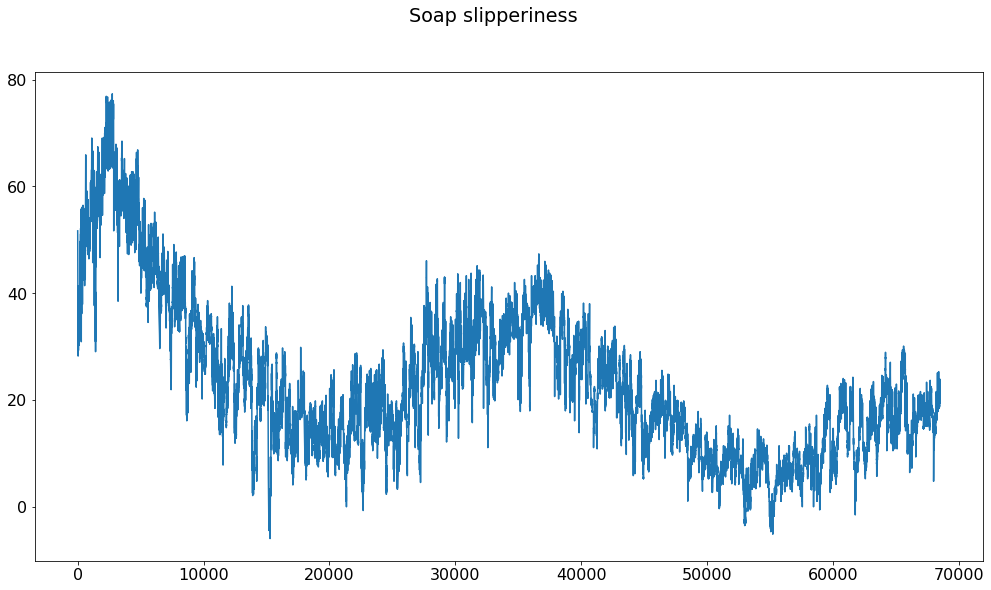

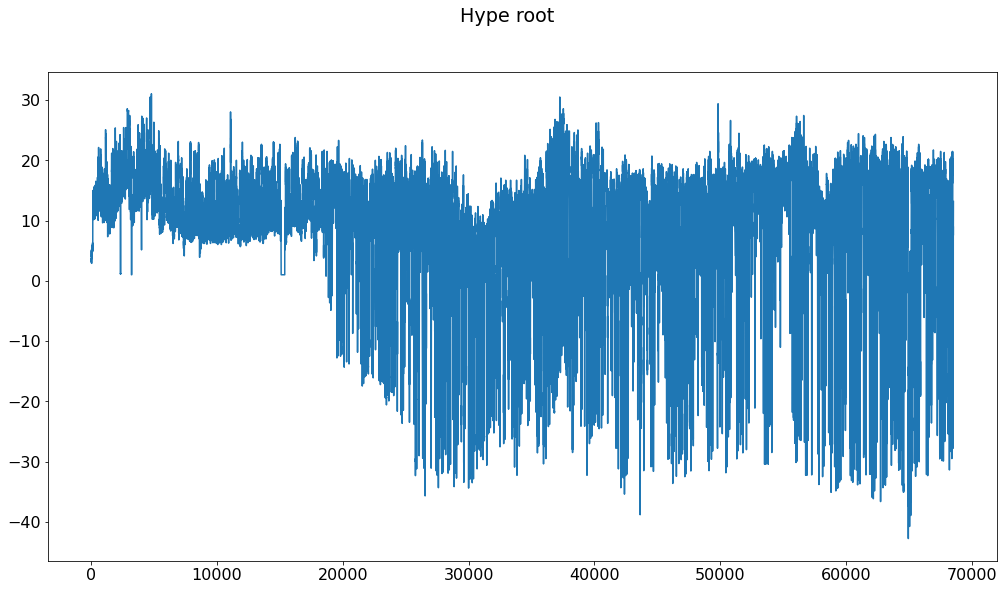

In [6]:
def inspect_feature(feature, dataframe):
    data = dataframe[feature]
    plt.figure(figsize=(17,9))
    axis = data.plot(subplots=True, figsize=(17, 9), title = feature)
    

for feature in list(df.columns):
    inspect_feature(feature, df)


In [7]:
test_split = df['Sponginess'].count() - int(df['Sponginess'].count() * 0.99)
df_test = df[:test_split]
df_train = df[:-test_split]
df_train.shape, df_test.shape

((67842, 7), (686, 7))

In [8]:
for feature in list(df.columns):
    X_max = df[feature].max()
    X_min = df[feature].min()
    X_diff = X_max - X_min
    df[feature] = (df[feature] - X_min) / X_diff
df.head(10)

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.556576,0.481134,0.612986,0.468044,0.613765,0.691885,0.629100
1,0.562874,0.485320,0.611573,0.465453,0.627575,0.690471,0.626693
2,0.559777,0.476949,0.611573,0.462934,0.606973,0.682070,0.626693
3,0.559777,0.476949,0.611573,0.465453,0.606973,0.621844,0.626693
4,0.550279,0.485320,0.610160,0.465453,0.620783,0.637254,0.626693
5,0.547181,0.476949,0.605921,0.462934,0.599955,0.635860,0.625905
6,0.528288,0.472764,0.603096,0.460343,0.613765,0.634447,0.623498
7,0.515693,0.468578,0.598857,0.457824,0.599955,0.623258,0.623498
8,0.512595,0.464393,0.598857,0.460343,0.586144,0.637254,0.621901
9,0.512595,0.468578,0.598857,0.465453,0.579352,0.631660,0.623498


In [9]:
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels


In [10]:
target_labels = df.columns
window = 150
stride = 5
telescope = 864
X_train, y_train = build_sequences(df_train, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(df_test, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13388, 150, 7), (13388, 864, 7), (0,), (0,))

In [11]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

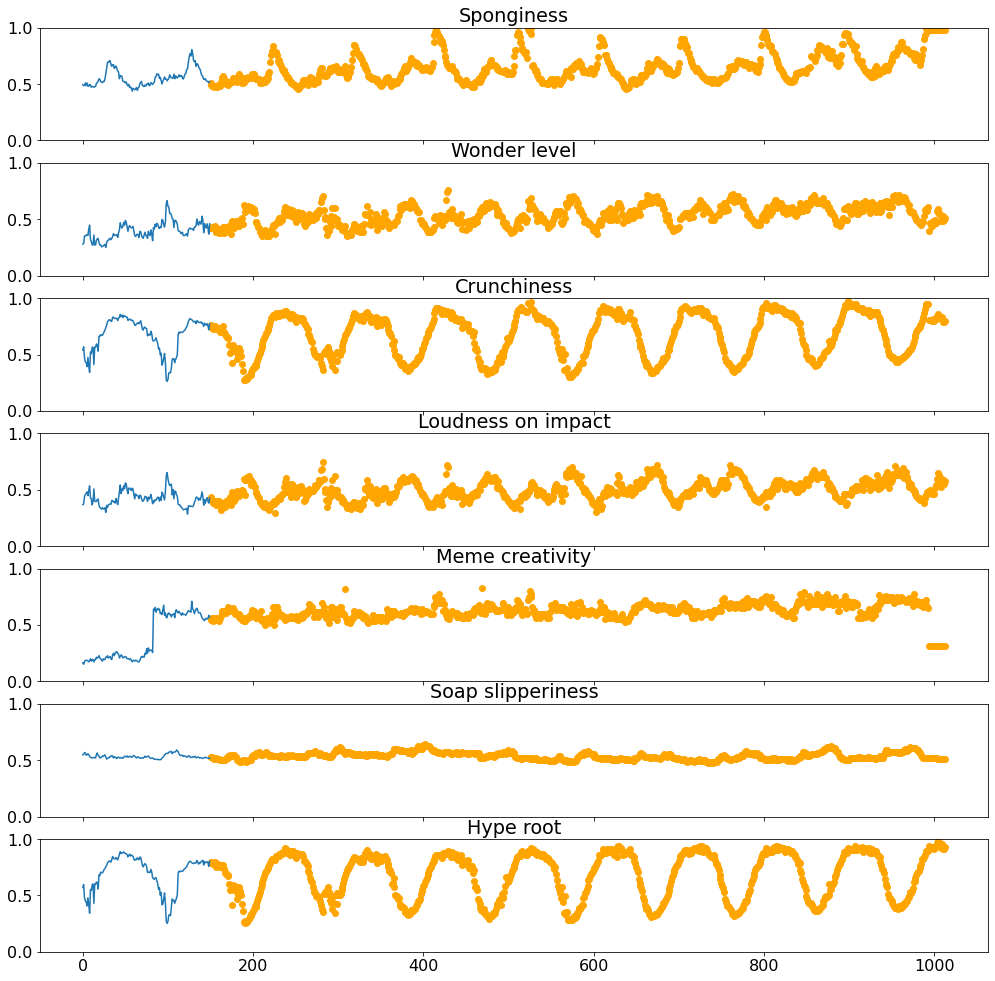

In [12]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [13]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 200

In [14]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [15]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 150, 7)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 150, 64)          10240     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 150, 128)          24704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 75, 128)          0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 75, 128)          98816     
 nal)                                                            
                                                             

In [17]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
377/377 [==============================] - 10s 26ms/step - loss: 0.0290 - mae: 0.1257 - val_loss: 0.0223 - val_mae: 0.1162 - lr: 0.0010
Epoch 2/200
377/377 [==============================] - 9s 24ms/step - loss: 0.0167 - mae: 0.0981 - val_loss: 0.0198 - val_mae: 0.1049 - lr: 0.0010
Epoch 3/200
377/377 [==============================] - 10s 25ms/step - loss: 0.0152 - mae: 0.0928 - val_loss: 0.0168 - val_mae: 0.0923 - lr: 0.0010
Epoch 4/200
377/377 [==============================] - 8s 22ms/step - loss: 0.0128 - mae: 0.0855 - val_loss: 0.0136 - val_mae: 0.0848 - lr: 0.0010
Epoch 5/200
377/377 [==============================] - 8s 22ms/step - loss: 0.0115 - mae: 0.0808 - val_loss: 0.0126 - val_mae: 0.0831 - lr: 0.0010
Epoch 6/200
377/377 [==============================] - 8s 22ms/step - loss: 0.0107 - mae: 0.0776 - val_loss: 0.0132 - val_mae: 0.0866 - lr: 0.0010
Epoch 7/200
377/377 [==============================] - 8s 22ms/step - loss: 0.0101 - mae: 0.0750 - val_loss: 0.0134 

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
model.save('drive/MyDrive/Models/verione_0.42_change_model')